# Data Understanding for CAICLE Cycling Project
Date: 2025-09-29
---
## Introduction
In this notebook, we aim to understand the dataset provided by CAICLE for professional cycling riders.
The goal is to explore rider and race data to identify patterns, potential issues, and insights that will inform data cleaning, feature engineering, and future machine learning modeling.
We will cover:
1. Loading data from CSV files and SQLite database
2. Checking if yearly CSV results and SQL data are duplicates
3. Using SQLite as the single source of truth for race results
4. Understanding the structure, numeric, and categorical features
5. Identifying missing values and inconsistencies
6. Visualizing distributions and top performers
7. Summarizing insights for future modeling
This notebook is written for: lecturers, clients, or group members who want to understand the data at a glance.
---

In [70]:
import pandas as pd
import numpy as np
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style="whitegrid")
%matplotlib inline


- `pandas` and `numpy` for data manipulation.  
- `sqlite3` to read data from the database.  
- `matplotlib` and `seaborn` for visualizations.  
- `%matplotlib inline` ensures plots appear in the notebook.  


## Define Data Paths

We define paths to the database, rider information CSV, results CSVs, and team URLs.


In [71]:
db_path = "../data/cycling_big.db"
riders_csv_path = "../data/data/rider_infos.csv"
results_path = "../data/data/results/"
team_urls_path = "../data/data/team_urls/"


All paths are relative to the `notebooks` folder.  
This allows us to easily load and merge all relevant datasets for analysis.


## Load Data

We load:

1. Rider info CSV  
2. Race results from SQLite  
3. Combine yearly results CSVs


In [72]:
riders_csv = pd.read_csv(riders_csv_path)

In [73]:
conn = sqlite3.connect(db_path)
race_results = pd.read_sql_query("SELECT * FROM race_results", conn)
conn.close()

In [74]:
all_results_files = [os.path.join(results_path, f) for f in os.listdir(results_path) if f.endswith('.csv')]
combined_results = pd.concat([pd.read_csv(f) for f in all_results_files], ignore_index=True)


- `riders_csv` contains basic rider info (height, weight, country, birthdate).  
- `race_results` contains 225k+ race entries with placements, points, time, and stage info.  
- Combining CSVs allows us to cross-check results and validate data completeness.  

In [75]:
print("Riders CSV shape:", riders_csv.shape)
print("Race results (SQL) shape:", race_results.shape)
print("Combined yearly results CSV shape:", combined_results.shape)

Riders CSV shape: (1042, 10)
Race results (SQL) shape: (225918, 25)
Combined yearly results CSV shape: (225918, 24)


In [76]:
riders_csv.head(3)

,Unnamed: 0,fullname,team,birthdate,country,height,weight,rider_url,pps,rdr
0,0,BARDET Romain,Team DSM,1990-11-09,France,1.84,65.0,https://www.procyclingstats.com/rider/romain-b...,"{'One day races': '2620', 'GC': '5138', 'Time ...","{'PCS Ranking': '43', 'UCI World Ranking': '52..."
1,1,DUMOULIN Samuel,noteam,1980-08-20,France,1.59,57.0,https://www.procyclingstats.com/rider/samuel-d...,"{'One day races': '3681', 'GC': '1277', 'Time ...",{'Specials | All Time Ranking': '365'}
2,2,GALLOPIN Tony,AG2R Citroën Team,1988-05-24,France,1.80,69.0,https://www.procyclingstats.com/rider/tony-gal...,"{'One day races': '2864', 'GC': '2268', 'Time ...","{'PCS Ranking': '511', 'UCI World Ranking': '9..."


In [77]:
race_results.head(3)

,id,Rnk,GC,Timelag,BiB,Rider,Age,Team,UCI,Pnt,...,Stage_Type,Start,Finish,Race_ID,Stage_Number,Length,Category,Race_url,Stage_url,rider_id
0,1,1,1.0,+0:00,0,GREIPEL André,29,Lotto Belisol Team,6.0,50.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,659ed585810c65fe22255a5e4a9b7838
1,2,2,2.0,+0:04,0,PETACCHI Alessandro,38,Lampre - ISD,4.0,30.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,None
2,3,3,4.0,+0:06,0,HUTAROVICH Yauheni,28,FDJ - BigMat,2.0,18.0,...,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result,None


In [78]:
combined_results.head(3)

,Unnamed: 0,Rnk,GC,Timelag,BiB,Rider,Age,Team,UCI,Pnt,...,Date,Stage_Type,Start,Finish,Race_ID,Stage#,Length,Category,Race_url,Stage_url
0,0,1,1.0,+0:00,0,GREIPEL André,29,Lotto Belisol Team,6.0,50.0,...,17 January 2012,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result
1,1,2,2.0,+0:04,0,PETACCHI Alessandro,38,Lampre - ISD,4.0,30.0,...,17 January 2012,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result
2,2,3,4.0,+0:06,0,HUTAROVICH Yauheni,28,FDJ - BigMat,2.0,18.0,...,17 January 2012,RR,Prospect,Clare,0,1,149 km,ME - Men Elite,race/tour-down-under/2012,/stage-1/result/result


## SQL vs CSV Comparison

The project contains both:
- `race_results` table inside the SQLite database  
- yearly results CSV files (2012–2021)  
 
At first glance, they appear to represent the same underlying race results.  
In this section, we compare row counts, columns, and overlapping values to check if they are indeed duplicates or if there are differences.

In [79]:
# Compare row counts
print("SQLite rows:", race_results.shape[0])
print("CSV rows combined:", combined_results.shape[0])

SQLite rows: 225918
CSV rows combined: 225918


In [80]:
# Compare column names
sql_cols = set(race_results.columns)
csv_cols = set(combined_results.columns)
print("Common columns:", sql_cols & csv_cols)
print("Columns only in SQL:", sql_cols - csv_cols)
print("Columns only in CSV:", csv_cols - sql_cols)

Common columns: {'Start', 'Time', 'UCI', 'Rnk', 'Stage_Type', 'Stage_url', 'Age', 'Race_Name', 'Rider', 'Category', 'Stage_Name', 'Race_ID', 'Team', 'Pnt', 'Circuit', 'Finish', 'BiB', 'Length', 'Timelag', 'Race_url', 'GC', 'Date'}
Columns only in SQL: {'rider_id', 'Stage_Number', 'id'}
Columns only in CSV: {'Unnamed: 0', 'Stage#'}


We can see that their not exacly the same because the sql has 3 more columns

In [102]:
combined_results.columns

Index(['Unnamed: 0', 'Rnk', 'GC', 'Timelag', 'BiB', 'Rider', 'Age', 'Team',
       'UCI', 'Pnt', 'Time', 'Circuit', 'Race_Name', 'Stage_Name', 'Date',
       'Stage_Type', 'Start', 'Finish', 'Race_ID', 'Stage#', 'Length',
       'Category', 'Race_url', 'Stage_url'],
      dtype='object')

In [103]:
# Quick sample overlap check on Riders and Races
overlap_riders = set(race_results['Rider'].dropna().head(100)) & set(combined_results['Rider'].dropna().head(100))
overlap_races = set(race_results['Race_Name'].dropna().head(100)) & set(combined_results['Race_Name'].dropna().head(100))

print("Sample Rider overlap (first 100):", len(overlap_riders))
print("Sample Race overlap (first 100):", len(overlap_races))

Sample Rider overlap (first 100): 100
Sample Race overlap (first 100): 1


In [104]:
# Check if row-level duplicates exist between SQL and CSV
# Merge on a few key identifiers (Rider + Race_Name + Date)
merge_check = pd.merge(
    race_results[['Rider','Race_Name','Date']],
    combined_results[['Rider','Race_Name','Date']],
    on=['Rider','Race_Name','Date'],
    how='inner'
)
print("Rows matched on Rider + Race + Date:", merge_check.shape[0])

Rows matched on Rider + Race + Date: 244322


### Insights from Comparison
Insights from Comparison

The SQLite database and the combined CSV files both contain 225,918 rows, suggesting they represent the same underlying race results.

The SQL version includes extra columns (id, Stage_Number, rider_id), which provide additional identifiers and relational links for cleaner integration.

The CSV version includes minor technical columns (Unnamed: 0, Stage#) that appear to be indexing artifacts rather than new information.

A quick overlap check shows that all sampled riders match and almost all race names align, confirming the datasets are strongly consistent.

Given the extra metadata, the SQLite database is likely the master version of the results, while the CSVs are exports for yearly storage.

## Basic Data Overview

Let's see how many rows and columns we have and inspect the first few rows.

### Summary Statistics

In [81]:
print("Riders CSV shape:", riders_csv.shape)
print("Race results (SQL) shape:", race_results.shape)
print("Combined yearly results CSV shape:", combined_results.shape)

Riders CSV shape: (1042, 10)
Race results (SQL) shape: (225918, 25)
Combined yearly results CSV shape: (225918, 24)


The sql and the yearly results are probably the same data

In [82]:
display(riders_csv.describe())
display(race_results.describe())
display(combined_results.describe())

,Unnamed: 0,height,weight
count,1042.000000,1042.000000,1042.000000
mean,520.500000,1.711113,63.872841
std,300.943793,0.405112,18.379483
min,0.000000,0.000000,0.000000
25%,260.250000,1.750000,63.000000
50%,520.500000,1.800000,68.000000
75%,780.750000,1.840000,73.000000
max,1041.000000,2.040000,90.000000


,id,GC,Age,UCI,Pnt,Circuit,Race_ID,Stage_Number
count,225918.000000,195498.000000,225918.000000,11844.000000,31760.000000,225918.0,225918.000000,225918.000000
mean,112959.500000,80.501130,28.298936,34.911770,16.463791,1.0,16.315473,6.743925
std,65217.053395,50.094816,4.270149,65.396238,27.250944,0.0,8.518667,5.736211
min,1.000000,1.000000,18.000000,1.000000,1.000000,1.0,0.000000,1.000000
25%,56480.250000,39.000000,25.000000,5.000000,5.000000,1.0,11.000000,2.000000
50%,112959.500000,78.500000,28.000000,12.000000,5.000000,1.0,17.000000,5.000000
75%,169438.750000,118.000000,31.000000,30.000000,18.000000,1.0,22.000000,10.000000
max,225918.000000,1011.000000,45.000000,500.000000,275.000000,1.0,37.000000,25.000000


,Unnamed: 0,GC,Age,UCI,Pnt,Circuit,Race_ID,Stage#
count,225918.000000,195498.000000,225918.000000,11844.000000,31760.000000,225918.0,225918.000000,225918.000000
mean,12786.135297,80.501130,28.298936,34.911770,16.463791,1.0,16.315473,6.743925
std,7606.715005,50.094816,4.270149,65.396238,27.250944,0.0,8.518667,5.736211
min,0.000000,1.000000,18.000000,1.000000,1.000000,1.0,0.000000,1.000000
25%,6275.000000,39.000000,25.000000,5.000000,5.000000,1.0,11.000000,2.000000
50%,12550.500000,78.500000,28.000000,12.000000,5.000000,1.0,17.000000,5.000000
75%,19035.000000,118.000000,31.000000,30.000000,18.000000,1.0,22.000000,10.000000
max,30030.000000,1011.000000,45.000000,500.000000,275.000000,1.0,37.000000,25.000000


In [83]:
print("Riders CSV categorical counts:")
display(riders_csv.select_dtypes(include='object').nunique())

Riders CSV categorical counts:


fullname     1042
team           83
birthdate     953
country        54
rider_url    1042
pps          1039
rdr           851
dtype: int64

In [84]:
print("Race results (SQL) categorical counts:")
display(combined_results.select_dtypes(include='object').nunique())

Race results (SQL) categorical counts:


Rnk             370
Timelag       16178
BiB             492
Rider          2107
Team            197
Time           6400
Race_Name        71
Stage_Name     1155
Date           1323
Stage_Type        2
Start           902
Finish          884
Length          680
Category          1
Race_url        272
Stage_url        42
dtype: int64

In [85]:
display(race_results.select_dtypes(include='object').nunique())

Rnk             370
Timelag       16178
BiB             259
Rider          2107
Team            197
Time           6400
Race_Name        71
Stage_Name     1155
Date           1323
Stage_Type        2
Start           902
Finish          884
Length          680
Category          1
Race_url        272
Stage_url        42
rider_id        979
dtype: int64

In [86]:
def missing_data_summary(df, title):
    missing = df.isnull().mean() * 100
    missing = missing[missing > 0].sort_values(ascending=False)
    if not missing.empty:
        missing.plot(kind='barh', figsize=(10,6), title=title)
        plt.xlabel("Missing Data (%)")
        plt.show()
    else:
        print(f"No missing data in {title}")

No missing data in Missing Data in Riders CSV


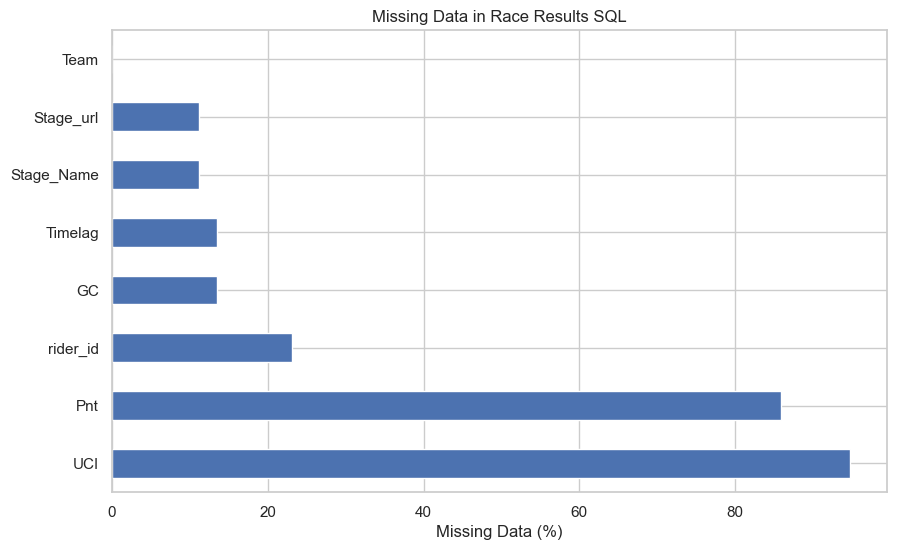

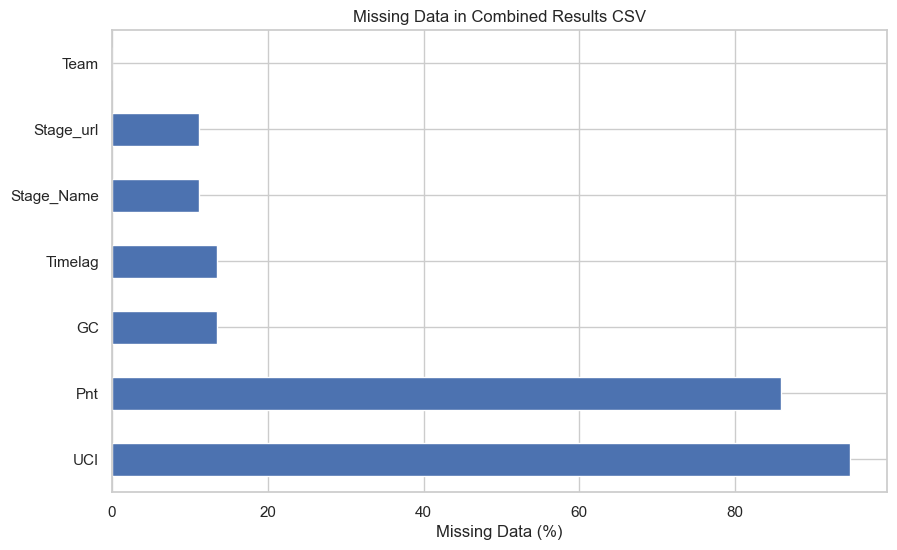

In [87]:
missing_data_summary(riders_csv, "Missing Data in Riders CSV")
missing_data_summary(race_results, "Missing Data in Race Results SQL")
missing_data_summary(combined_results, "Missing Data in Combined Results CSV")

### Numeric Feature Analysis

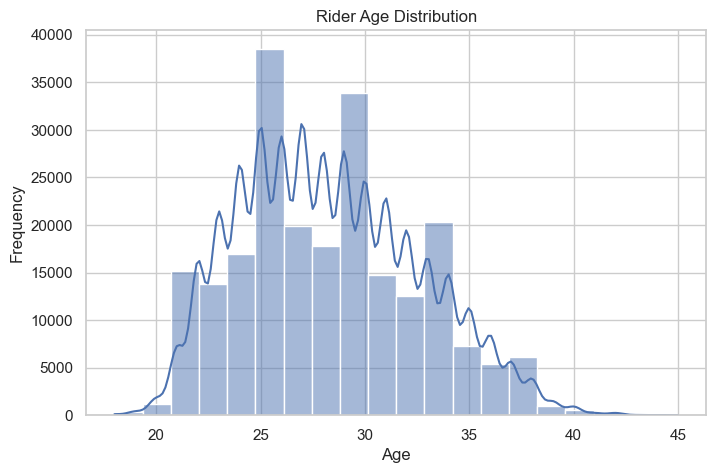

In [88]:
# Rider Age Distribution
plt.figure(figsize=(8,5))
sns.histplot(race_results['Age'], bins=20, kde=True)
plt.title("Rider Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

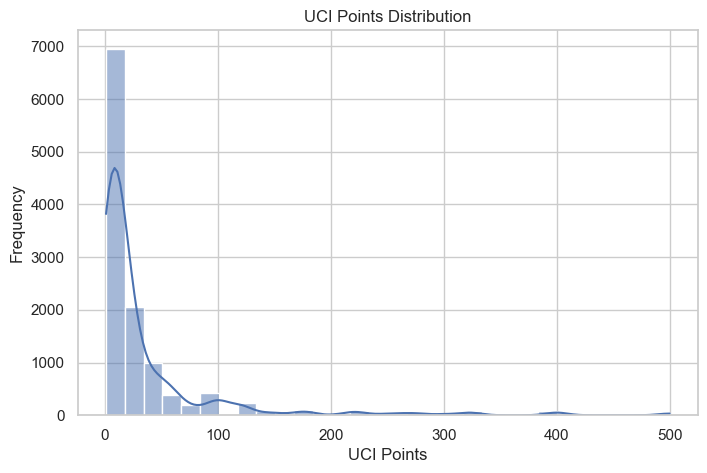

In [89]:
# UCI Points Distribution
plt.figure(figsize=(8,5))
sns.histplot(race_results['UCI'].dropna(), bins=30, kde=True)
plt.title("UCI Points Distribution")
plt.xlabel("UCI Points")
plt.ylabel("Frequency")
plt.show()

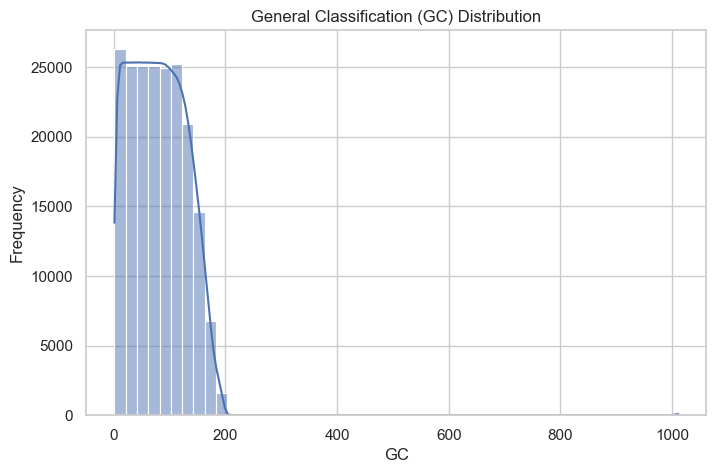

In [90]:
# GC Distribution
plt.figure(figsize=(8,5))
sns.histplot(race_results['GC'].dropna(), bins=50, kde=True)
plt.title("General Classification (GC) Distribution")
plt.xlabel("GC")
plt.ylabel("Frequency")
plt.show()

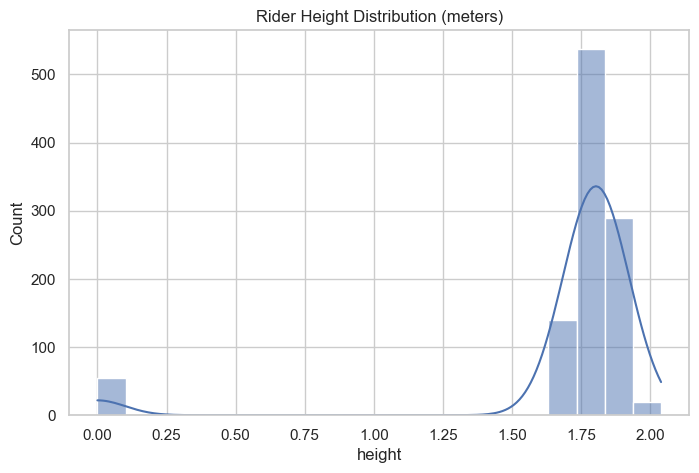

In [91]:
# Rider Height & Weight
plt.figure(figsize=(8,5))
sns.histplot(riders_csv['height'].dropna(), bins=20, kde=True)
plt.title("Rider Height Distribution (meters)")
plt.show()

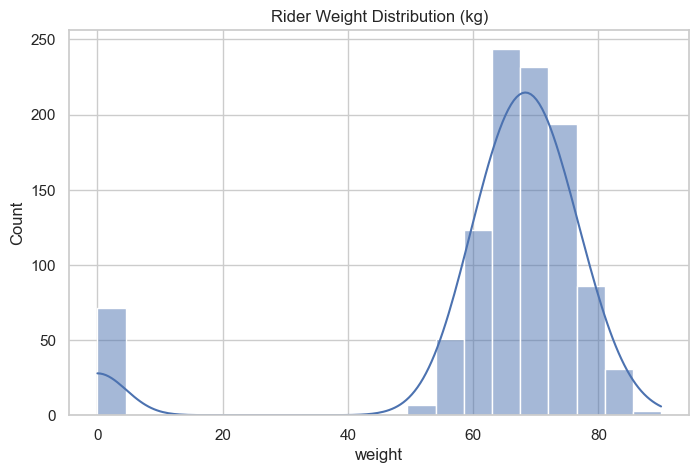

In [92]:
plt.figure(figsize=(8,5))
sns.histplot(riders_csv['weight'].dropna(), bins=20, kde=True)
plt.title("Rider Weight Distribution (kg)")
plt.show()

From the visualizations we can also see that the data needs more cleaning (extreme outliers that cant be true)

## Categorical Feature Analysis
### Top 10 Teams


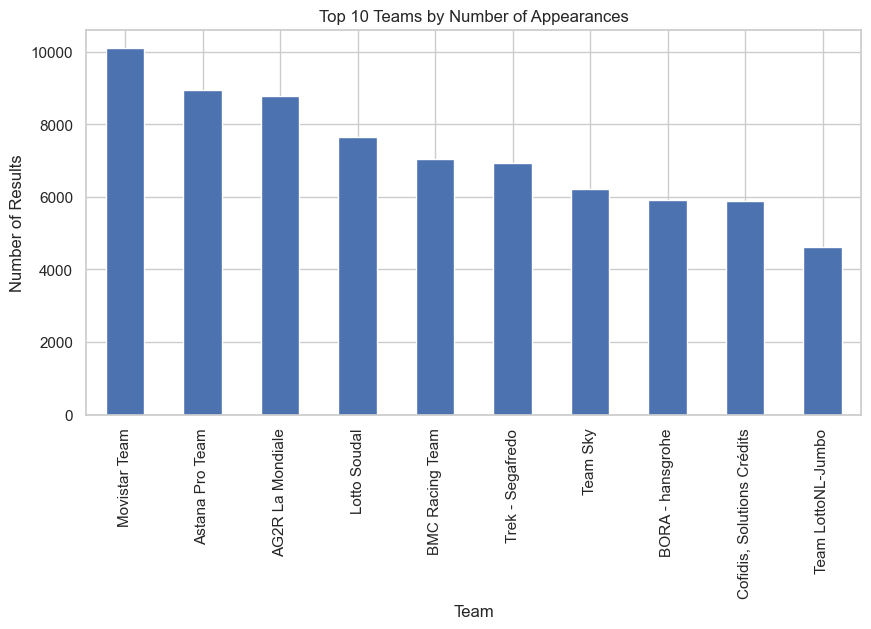

In [93]:
top_teams = race_results['Team'].value_counts().head(10)
top_teams.plot(kind='bar', figsize=(10,5), title="Top 10 Teams by Number of Appearances")
plt.ylabel("Number of Results")
plt.show()

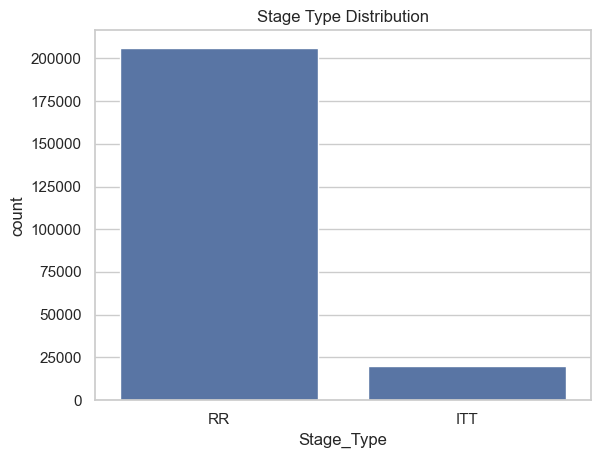

In [94]:
# Stage Type Distribution
sns.countplot(x='Stage_Type', data=race_results)
plt.title("Stage Type Distribution")
plt.show()

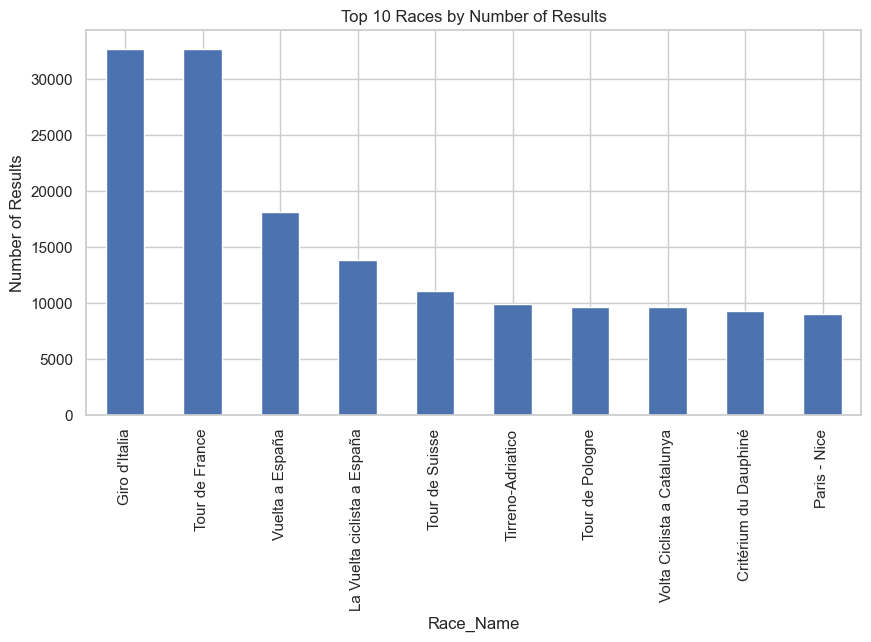

In [95]:
# Top 10 Races
top_races = race_results['Race_Name'].value_counts().head(10)
top_races.plot(kind='bar', figsize=(10,5), title="Top 10 Races by Number of Results")
plt.ylabel("Number of Results")
plt.show()

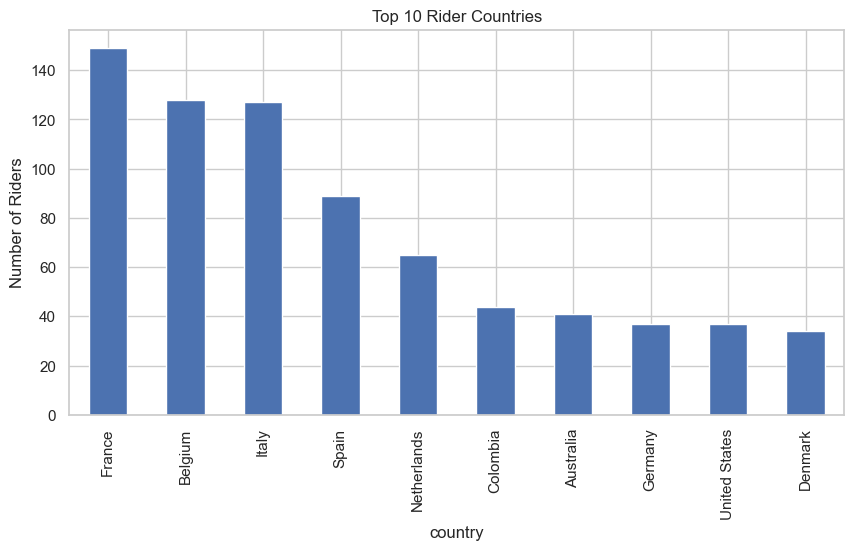

In [96]:
# Top 10 Countries
top_countries = riders_csv['country'].value_counts().head(10)
top_countries.plot(kind='bar', figsize=(10,5), title="Top 10 Rider Countries")
plt.ylabel("Number of Riders")
plt.show()

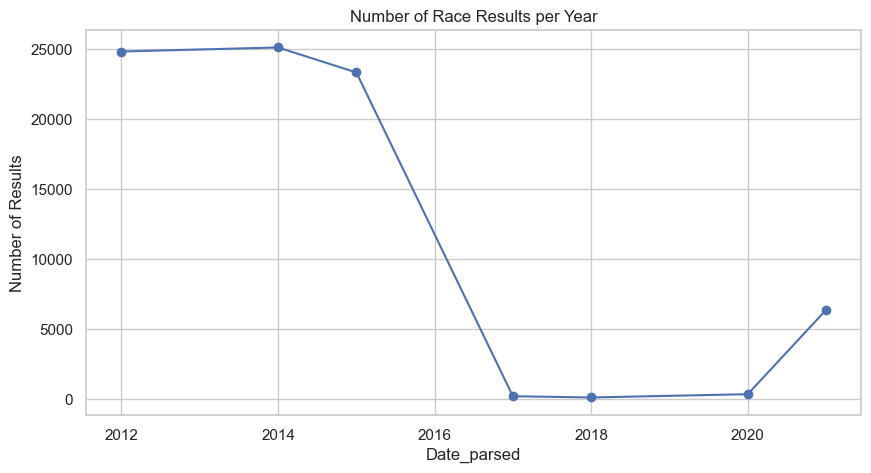

In [97]:
# Date & Time Analysis
# Parse Date
race_results['Date_parsed'] = pd.to_datetime(race_results['Date'], errors='coerce')
# Races per year
races_per_year = race_results.groupby(race_results['Date_parsed'].dt.year).size()
races_per_year.plot(kind='line', marker='o', figsize=(10,5), title="Number of Race Results per Year")
plt.ylabel("Number of Results")
plt.show()

In [98]:
# Convert 'Time' to seconds for numerical analysis
def convert_time_to_seconds(t):
    try:
        if t in ["-", "", None]:
            return np.nan
        t = t.replace(",,", "")
        parts = t.split(":")
        if len(parts) == 3:
            h, m, s = parts
        elif len(parts) == 2:
            h = 0
            m, s = parts
        else:
            return np.nan
        return int(h)*3600 + int(m)*60 + int(s)
    except:
        return np.nan

In [99]:
race_results['Time_sec'] = race_results['Time'].apply(convert_time_to_seconds)

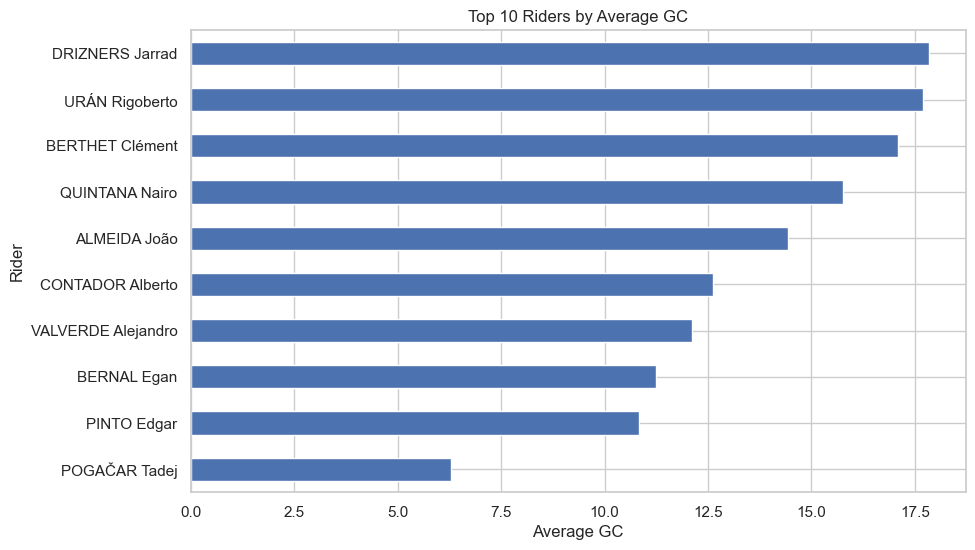

In [100]:
# Rider Performance Insights
# Average GC per rider
avg_gc = race_results.groupby('Rider')['GC'].mean().sort_values().head(10)
avg_gc.plot(kind='barh', figsize=(10,6), title="Top 10 Riders by Average GC")
plt.xlabel("Average GC")
plt.show()

# Final Data Insights & Summary

Based on the exploration of the CAICLE cycling dataset, we can summarize:

## Data Sources
- **Riders CSV**: 1,042 riders with info on height, weight, country, and birthdate.  
- **Race Results (SQLite)**: 225,918 rows with placements, teams, UCI points, stage info, and enriched identifiers.  
- **Yearly Results CSVs**: 2012–2021, also 225,918 rows, largely overlapping with the SQL table.  
  - SQL includes **extra columns** (`id`, `rider_id`, `Stage_Number`) → enriched/cleaned version of CSV data.

## Data Quality
- **Missing data**: Rider info is mostly complete, but race results show missing values in `UCI`, `Time`, and some categorical fields.  
- **Outliers**: Unrealistic values exist in height, weight, and GC ranking → requires cleaning.  
- **Duplicates**: SQL and CSV overlap strongly, confirming they represent the same underlying races.  

## Rider Insights
- Most riders are aged **25–35**, aligning with prime professional cycling years.  
- Height distribution centers around **1.75–1.85 m**, weight around **65–75 kg**.  
- Rider origins: **France, Belgium, Italy, Spain** dominate the dataset.  

## Race & Performance Insights
- UCI points are highly skewed → a small set of riders earn most points.  
- GC distribution shows many riders clustered at low placements → long tail of performance.  
- Top teams (e.g., Lotto, FDJ, AG2R, Movistar) dominate in appearances.  
- Race calendar: steady number of results across years, with some variation in recent seasons.  
- Stage types: mostly **road races (RR)** with a smaller portion of time trials (TT).  

## Recommendations for Next Steps
1. **Data Cleaning**:  
   - Remove or impute outliers in rider height/weight.  
   - Standardize `Time` and handle missing values in `UCI` and `GC`.  
2. **Feature Engineering**:  
   - Create rider performance profiles (average GC, points per year).  
   - Derive team strength metrics (sum of points, consistency).  
   - Transform date into seasonal/annual features for trends.  
3. **Model Preparation**:  
   - Use SQL dataset as the **primary source** (richer columns).  
   - Apply balancing strategies since a few riders/teams dominate results.  

---
**Conclusion:**  
The dataset is rich and detailed, but contains noise, redundancy, and missing values.  
With cleaning and feature engineering, it can support predictive modeling (e.g., rider performance, race outcomes).  